# ネットワークデータの読み込み

In [2]:
import pypsa

# 最適化済みネットワークデータを読み込む
network = pypsa.Network('./complete_network/optimized_network_2024.nc')
print(f"ネットワークデータを読み込みました: {len(network.buses)} buses, {len(network.generators)} generators")

INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores, sub_networks


ネットワークデータを読み込みました: 49 buses, 210 generators


c:\Users\takashi-yanase\AppData\Local\miniconda3\envs\pypsa_tepsco\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



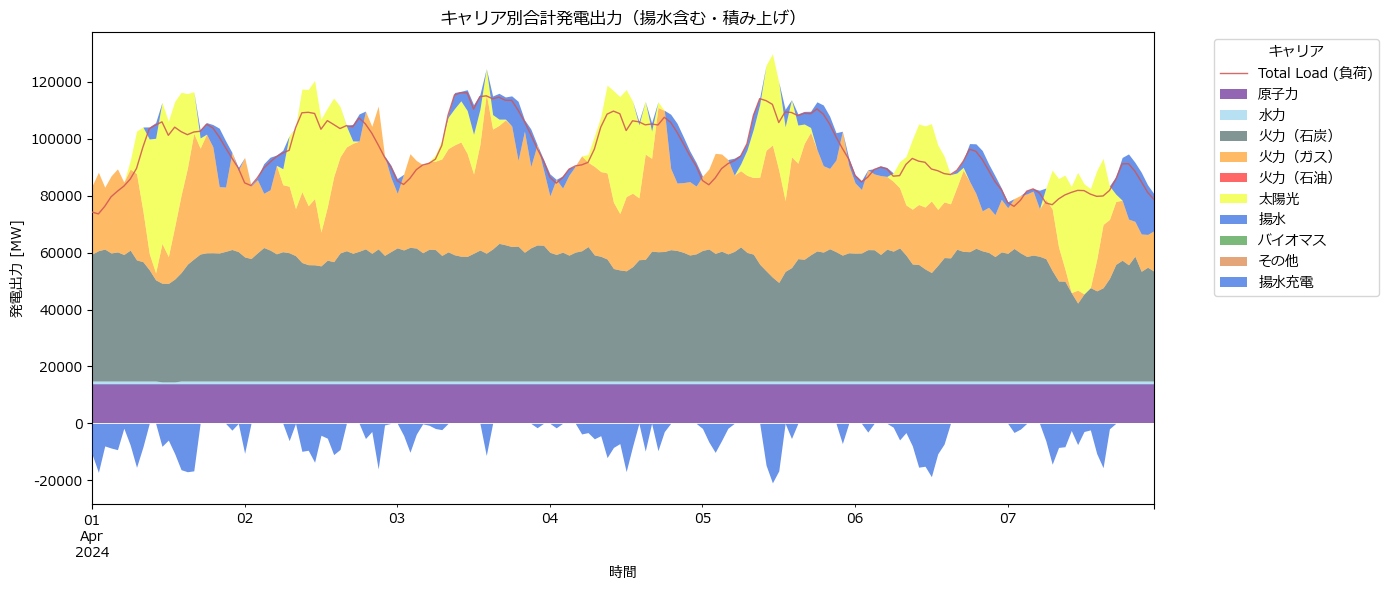

In [47]:
# 需給シミュレーション結果を表示
import src.analyze_results as analyze_results
import importlib
# モジュールを強制的にリロード
importlib.reload(analyze_results)
analyze_results.plot_total_generation_by_carrier(network)

ネットワーク内のcarrier一覧:
['その他', 'バイオマス', '原子力', '太陽光', '水力', '火力（ガス）', '火力（石油）', '火力（石炭）']


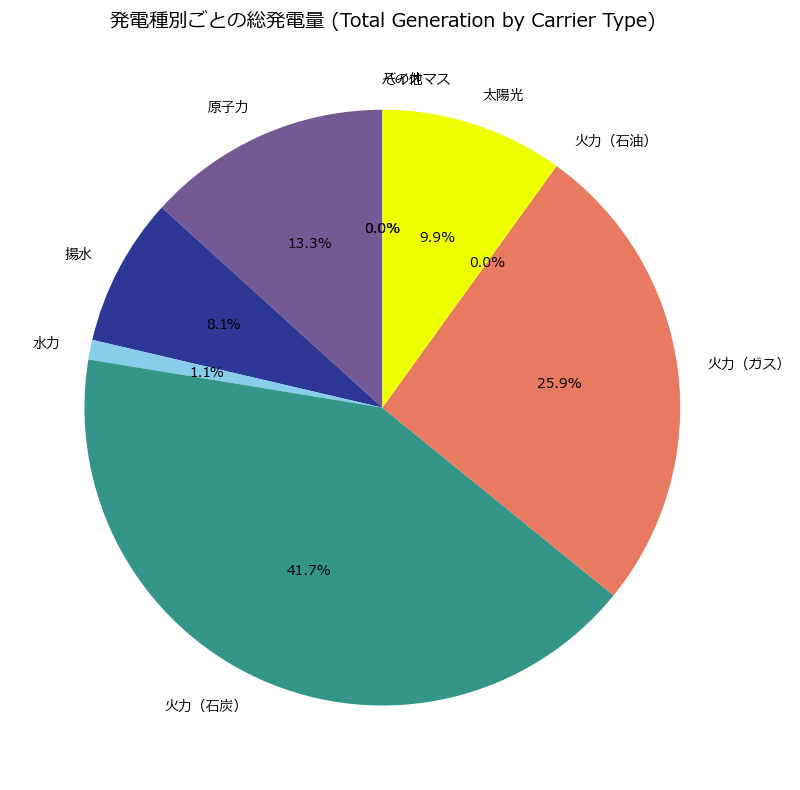

In [48]:
# 発電電力量を発電種別毎の円グラフで表示
import matplotlib.pyplot as plt

# 日本語フォント設定
plt.rcParams['font.family'] = 'Meiryo'  # Windows用
plt.rcParams['axes.unicode_minus'] = False  # マイナス記号の文字化け防止

desired_order = ["原子力", "揚水", "水力", "火力（石炭）", "火力（ガス）", "火力（石油）", "太陽光", "バイオマス", "その他"]
color_list = ["#745994", "#2C3796", "#87CEEB", "#339689", "#E77A61", "#FF0000", "#EEFF00", "#228B22", "#D2691E"]

# 発電種別ごとの総発電量を計算
generation_by_carrier = network.generators_t.p.sum().groupby(network.generators.carrier).sum()

# まずネットワークにどんなcarrierがあるか確認
print("ネットワーク内のcarrier一覧:")
print(generation_by_carrier.index.tolist())

# 揚水発電の発電量を追加
if hasattr(network, 'links'):
    phss_links = network.links[network.links['carrier'] == '揚水'].index
    if len(phss_links) > 0:
        phss_generation = network.links_t.p0[phss_links].clip(lower=0).sum().sum()
        generation_by_carrier['揚水'] = phss_generation

# desired_orderに従って並び替え（存在するもののみ）
ordered_generation = {}
for carrier in desired_order:
    if carrier in generation_by_carrier.index:
        ordered_generation[carrier] = generation_by_carrier[carrier]

# 色の対応を作成
colors_to_use = [color_list[desired_order.index(carrier)] for carrier in ordered_generation.keys()]

# 円グラフを作成
fig, ax = plt.subplots(figsize=(10, 8))
ax.pie(ordered_generation.values(), 
    labels=ordered_generation.keys(), 
    autopct='%1.1f%%',
    startangle=90, 
    colors=colors_to_use)
ax.set_title('発電種別ごとの総発電量 (Total Generation by Carrier Type)', fontsize=14)
plt.tight_layout()
plt.show()


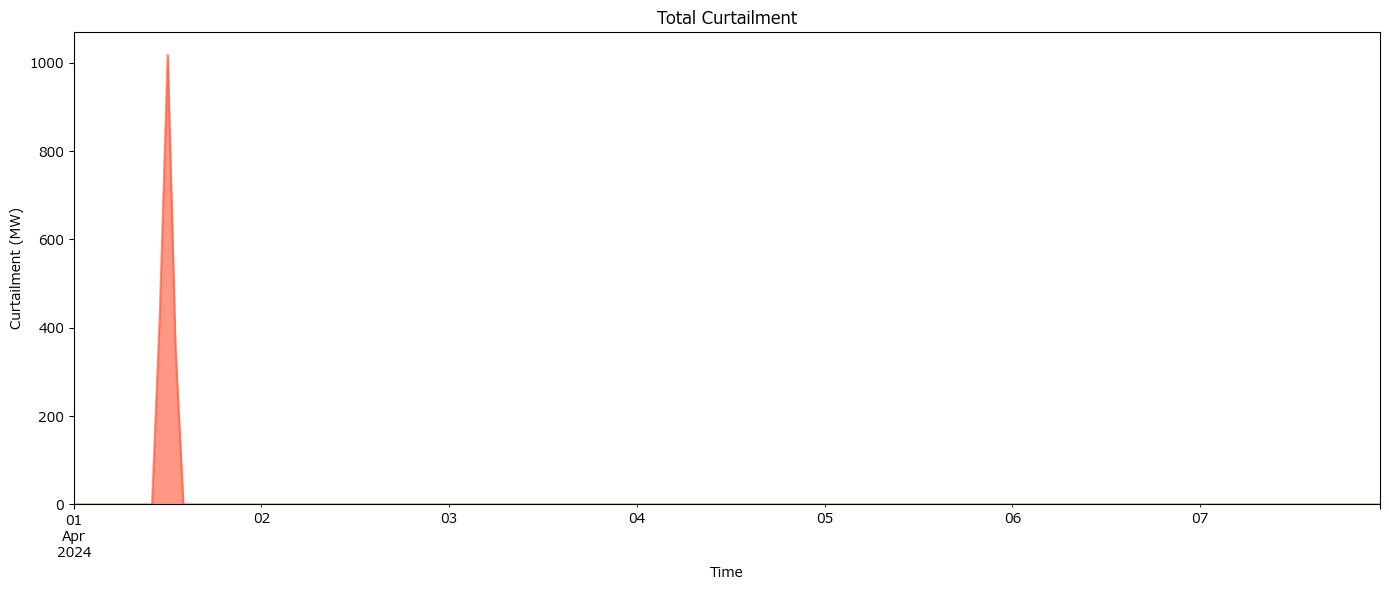

In [49]:
import matplotlib.pyplot as plt

# ネットワークの出力抑制（curtailment）を計算して表示
curtailment = network.generators_t.p_max_pu * network.generators.p_nom - network.generators_t.p

# 時系列の出力抑制をプロット
curtailment_positive = curtailment.clip(lower=0)
fig, ax = plt.subplots(figsize=(14, 6))
curtailment_positive.sum(axis=1).plot.area(ax=ax, title='Total Curtailment',
                                       ylabel='Curtailment (MW)', xlabel='Time', 
                                       stacked=True, color='#FF6347AA')
plt.tight_layout()
plt.show()

# 送電線の潮流を表示

プロット対象の連系線: 10本
['北海道本州連系設備', '東北東京間連系線', '東京中部間連系線', '中部北陸連系設備', '中部関西連系線', '北陸関西連系線', '関西中国間連系線', '関西四国間連系設備', '中国四国間連系線', '中国九州間連系線']


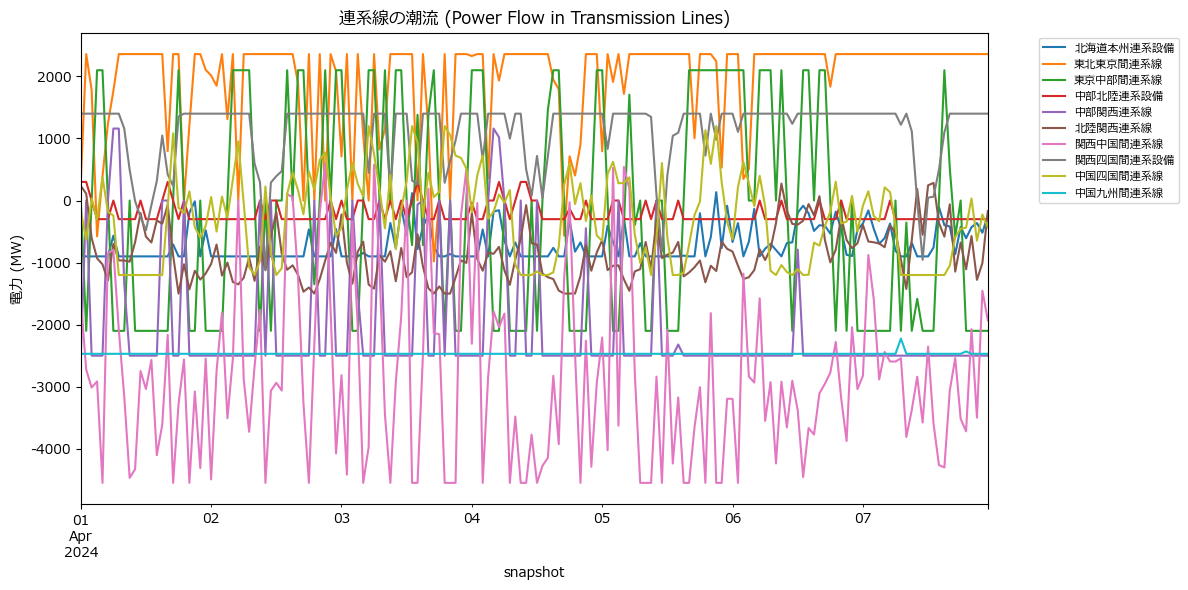

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

pd.options.plotting.backend = "matplotlib"  # プロットバックエンドをmatplotlibに
plt.rcParams['font.family'] = 'Meiryo'  # または 'Meiryo', 'Yu Gothic' MS Gothic
plt.rcParams['axes.unicode_minus'] = False  # マイナス符号も文字化け防止

# 連系線のみをフィルタリング（carrier='DC'または名前に'連系'を含むリンク）
transmission_links = network.links[
    (network.links['carrier'] == 'DC') | 
    (network.links.index.str.contains('連系', na=False))
].index

if len(transmission_links) > 0:
    network.links_t.p0[transmission_links].plot(
        title="連系線の潮流 (Power Flow in Transmission Lines)", 
        figsize=(12, 6),
        ylabel="電力 (MW)"
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    print(f"プロット対象の連系線: {len(transmission_links)}本")
    print(transmission_links.tolist())
else:
    print("連系線が見つかりませんでした")

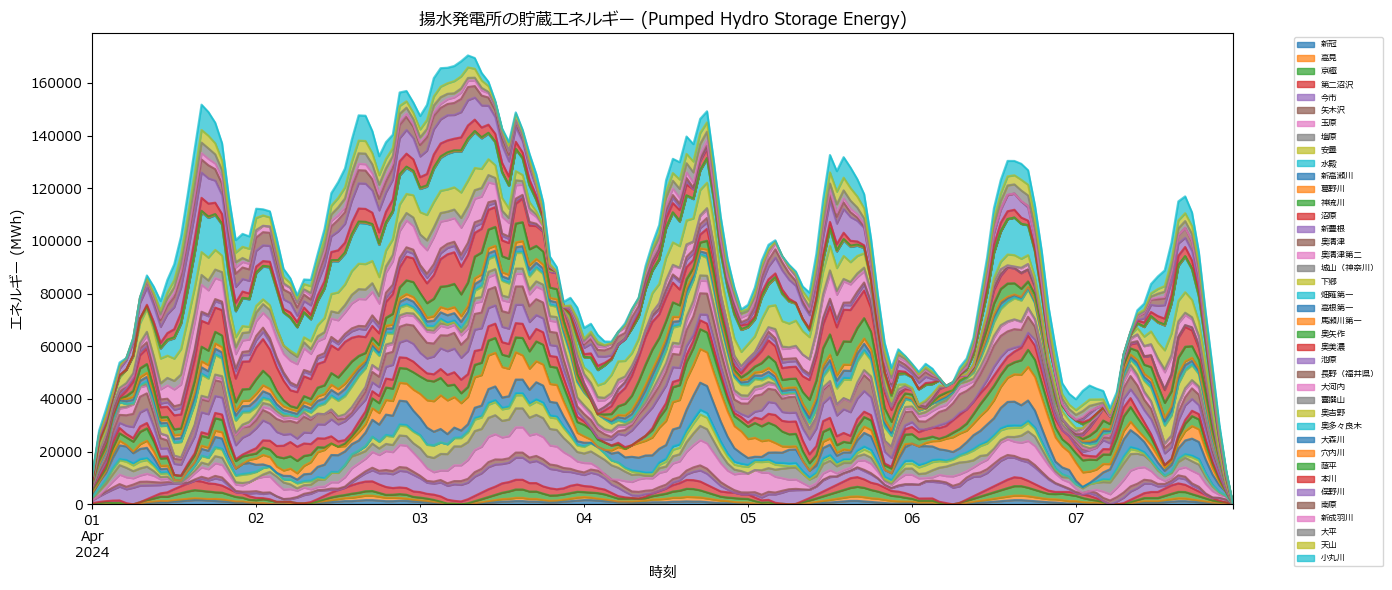

In [ ]:
# 揚水発電所のリンクを特定
pumped_hydro_links = network.links[network.links['carrier'] == '揚水'].index

# 揚水発電所の出力時系列データを取得
pumped_hydro_power = network.links_t.p0[pumped_hydro_links]

# 揚水発電所のリンク（発電・揚水）の出力をプロット
if len(pumped_hydro_links) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    pumped_hydro_power.plot(ax=ax, title='揚水発電所の出力 (Pumped Hydro Power Output)', 
                            ylabel='電力 (MW)', xlabel='時刻', legend=False)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("揚水発電所のリンクが見つかりませんでした")

In [ ]:
# 揚水発電所の貯蔵エネルギー（蓄電状態）を積み上げグラフでプロット
if len(network.stores) > 0:
    # 揚水発電所（Store）の蓄電量時系列データを取得
    storage_energy = network.stores_t.e
    
    if not storage_energy.empty:
        fig, ax = plt.subplots(figsize=(14, 6))
        storage_energy.plot(
            ax=ax, 
            kind='area',
            stacked=True,
            alpha=0.7,
            title='揚水発電所の貯蔵エネルギー (Pumped Hydro Storage Energy)', 
            ylabel='エネルギー (MWh)', 
            xlabel='時刻'
        )
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6)
        plt.tight_layout()
        plt.show()
    else:
        print("揚水発電所の貯蔵エネルギーデータがありません")
else:
    print("ネットワークに揚水発電所（Store）が含まれていません")

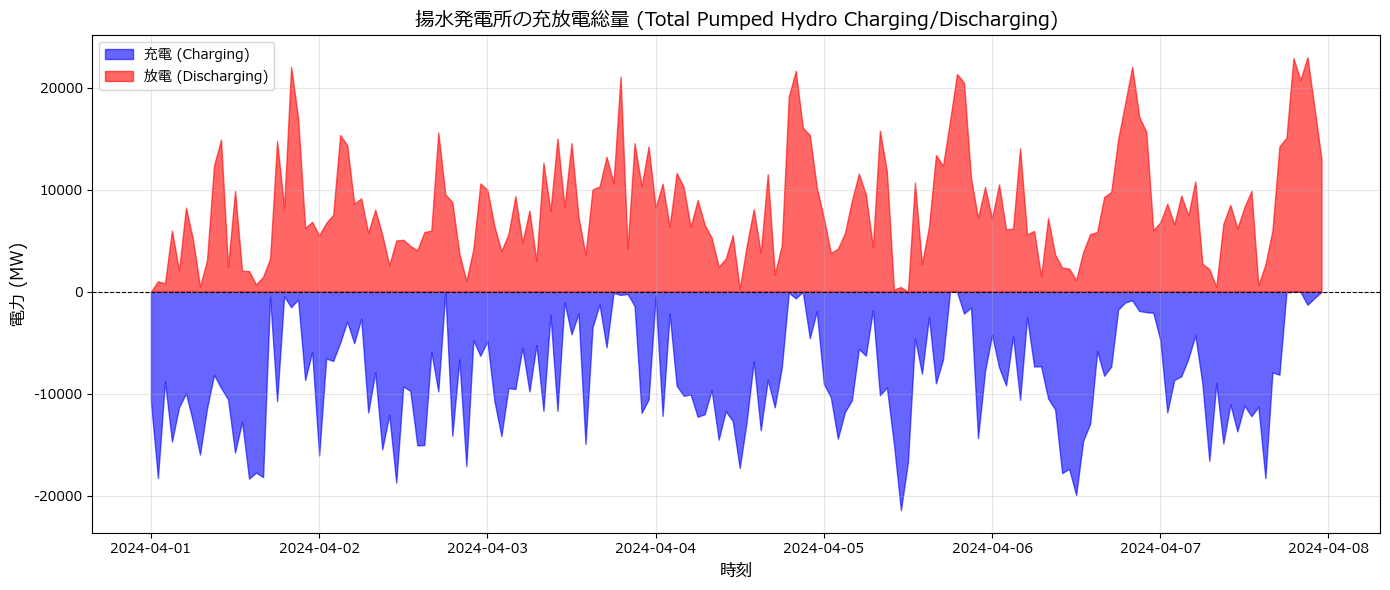

In [62]:
# 揚水発電所の充電（負値）と放電（正値）を分けて集計してプロット
# 充電量（負の値）と放電量（正の値）を分離
charging = pumped_hydro_power.clip(upper=0).sum(axis=1)  # 負の値（充電）
discharging = pumped_hydro_power.clip(lower=0).sum(axis=1)  # 正の値（放電）
  
# プロット
fig, ax = plt.subplots(figsize=(14, 6))
ax.fill_between(charging.index, charging, 0, alpha=0.6, color='blue', label='充電 (Charging)')
ax.fill_between(discharging.index, 0, discharging, alpha=0.6, color='red', label='放電 (Discharging)')
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax.set_title('揚水発電所の充放電総量 (Total Pumped Hydro Charging/Discharging)', fontsize=14)
ax.set_ylabel('電力 (MW)', fontsize=12)
ax.set_xlabel('時刻', fontsize=12)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 地図上にプロットする。

In [35]:
import folium
import pandas as pd

# Helper: try various column names and return DataFrame with lat/lon
def _get_bus_locations_df(network):
    df = network.buses.copy()
    # common PyPSA default: x (lon), y (lat)
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    # already lat/lon
    elif {'lat','lon'}.issubset(df.columns):
        pass
    # alternative naming
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    # some workflows store coords in a list/tuple column called 'coords'
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    # ensure numeric and drop invalid rows
    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

# get bus locations (raises helpful error if not found)
bus_locations = _get_bus_locations_df(network)

# 地図の中心をバスの平均位置に設定
center_lat = bus_locations['lat'].mean()
center_lon = bus_locations['lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=5)

# バスごとにマーカーを追加
for bus_name, row in bus_locations.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=str(bus_name),
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

# 保存と表示
m.save('bus_locations_map.html')

m

In [18]:
# プロット: バスとリンク（network.links / network.lines）を地図上に描画して保存
# 既に folium, network, Year_of_analysis が定義されている前提
import folium, pandas as pd

# 再利用可能なバス位置取得関数 (cell '#VSC-50c70af2' と同じロジック)
def _get_bus_locations_df(network):
    df = network.buses.copy()
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    elif {'lat','lon'}.issubset(df.columns):
        pass
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

# バス位置取得
bus_locations = _get_bus_locations_df(network)

m_links = folium.Map(location=[bus_locations['lat'].mean(), bus_locations['lon'].mean()], zoom_start=5)

# バスをマーカーで追加
for bus_name, r in bus_locations.iterrows():
    folium.CircleMarker(
        location=[r['lat'], r['lon']],
        radius=6,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        popup=str(bus_name)
    ).add_to(m_links)

# 汎用的にリンクのバス列を検出して描画する関数
def _plot_links_from_df(df, color='#d63333', weight=3, prefix=''):
    bus_cols = [c for c in df.columns if c.startswith('bus')]
    if len(bus_cols) < 2:
        return 0
    count = 0
    for name, row in df.iterrows():
        b0 = row[bus_cols[0]]
        b1 = row[bus_cols[1]]
        # bus 名が bus_locations にあるか確認
        if (b0 in bus_locations.index) and (b1 in bus_locations.index):
            coords = [
                [bus_locations.loc[b0, 'lat'], bus_locations.loc[b0, 'lon']],
                [bus_locations.loc[b1, 'lat'], bus_locations.loc[b1, 'lon']]
            ]
            popup = f"{prefix}{name}: {b0} ↔ {b1}"
            folium.PolyLine(coords, color=color, weight=weight, opacity=0.7, popup=popup).add_to(m_links)
            count += 1
    return count

# network.links があれば描画
links_plotted = 0
if hasattr(network, "links") and len(network.links) > 0:
    links_plotted += _plot_links_from_df(network.links, color='#ff4500', weight=3, prefix='link ')

# network.lines があれば描画（存在するネットワークでは lines が無い場合もある）
if hasattr(network, "lines") and len(network.lines) > 0:
    links_plotted += _plot_links_from_df(network.lines, color='#0066cc', weight=2, prefix='line ')

# 出力・保存
out_file = f'bus_links_map.html'
m_links.save(out_file)
print(f"バス: {len(bus_locations)} 個、リンク描画: {links_plotted} 本。地図を保存しました -> {out_file}")

# Jupyter で表示するためにマップオブジェクトを返す
m_links


バス: 49 個、リンク描画: 50 本。地図を保存しました -> bus_links_map.html


In [20]:
# Duplicate plotting cell made robust as well
import folium

# re-use the helper from earlier; define again to be safe in isolation
def _get_bus_locations_df(network):
    df = network.buses.copy()
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    elif {'lat','lon'}.issubset(df.columns):
        pass
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

bus_locations = _get_bus_locations_df(network)

m_links = folium.Map(location=[bus_locations['lat'].mean(), bus_locations['lon'].mean()], zoom_start=5)

# バスをマーカーで追加
for bus_name, r in bus_locations.iterrows():
    folium.CircleMarker(
        location=[r['lat'], r['lon']],
        radius=6,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        popup=str(bus_name)
    ).add_to(m_links)

# 汎用的にリンクのバス列を検出して描画する関数
def _plot_links_from_df(df, color='#d63333', weight=3, prefix=''):
    bus_cols = [c for c in df.columns if c.startswith('bus')]
    if len(bus_cols) < 2:
        return 0
    count = 0
    for name, row in df.iterrows():
        b0 = row[bus_cols[0]]
        b1 = row[bus_cols[1]]
        if (b0 in bus_locations.index) and (b1 in bus_locations.index):
            coords = [
                [bus_locations.loc[b0, 'lat'], bus_locations.loc[b0, 'lon']],
                [bus_locations.loc[b1, 'lat'], bus_locations.loc[b1, 'lon']]
            ]
            popup = f"{prefix}{name}: {b0} ↔ {b1}"
            folium.PolyLine(coords, color=color, weight=weight, opacity=0.7, popup=popup).add_to(m_links)
            count += 1
    return count

links_plotted = 0
if hasattr(network, "links") and len(network.links) > 0:
    links_plotted += _plot_links_from_df(network.links, color='#ff4500', weight=3, prefix='link ')

if hasattr(network, "lines") and len(network.lines) > 0:
    links_plotted += _plot_links_from_df(network.lines, color='#0066cc', weight=2, prefix='line ')

out_file = f'bus_links_map.html'
m_links.save(out_file)
print(f"バス: {len(bus_locations)} 個、リンク描画: {links_plotted} 本。地図を保存しました -> {out_file}")

m_links


バス: 49 個、リンク描画: 50 本。地図を保存しました -> bus_links_map.html


地図にバス情報を追加します...
  バス '北海道': 479876 MWh (8 種類)
  バス '東北': 1996463 MWh (5 種類)
  バス '東京': 4809475 MWh (7 種類)
  バス '北陸': 435846 MWh (7 種類)
  バス '東京': 4809475 MWh (7 種類)
  バス '北陸': 435846 MWh (7 種類)
  バス '中部': 2141997 MWh (7 種類)
  バス '関西': 2752652 MWh (7 種類)
  バス '中部': 2141997 MWh (7 種類)
  バス '関西': 2752652 MWh (7 種類)
  バス '四国': 342934 MWh (5 種類)
  バス '中国': 1097522 MWh (8 種類)
  バス '九州': 1967776 MWh (7 種類)
  バス '四国': 342934 MWh (5 種類)
  バス '中国': 1097522 MWh (8 種類)
  バス '九州': 1967776 MWh (7 種類)
バスごとの発電量円グラフ地図を保存しました -> bus_generation_pie_map.html
バスごとの発電量円グラフ地図を保存しました -> bus_generation_pie_map.html



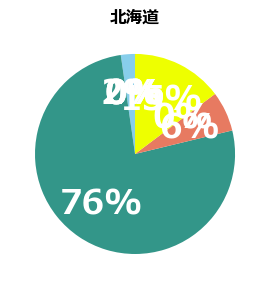
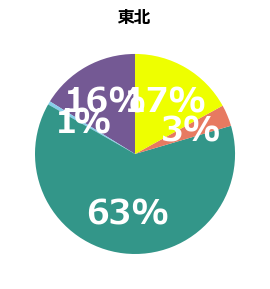
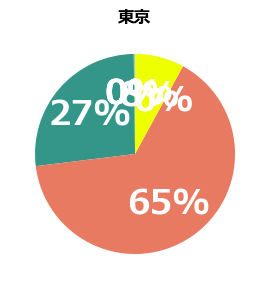
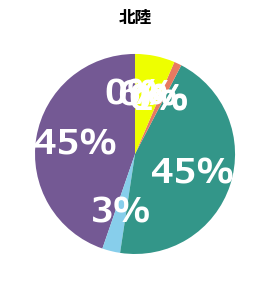
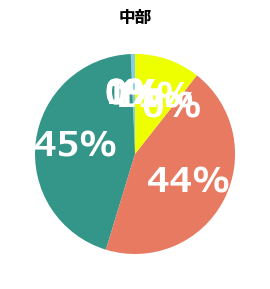
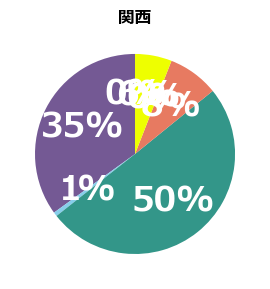
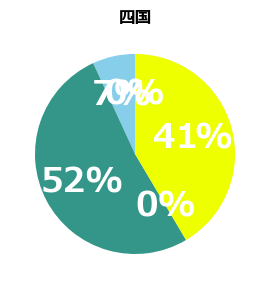
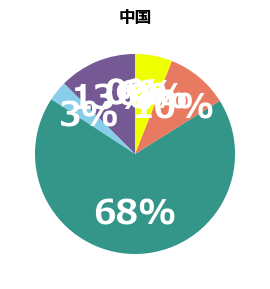
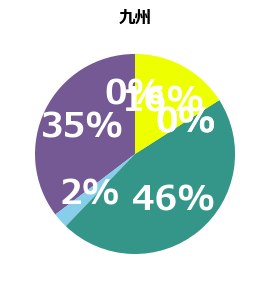

In [ ]:
import folium
from folium import plugins
import io
import base64
import pandas as pd
import matplotlib.pyplot as plt

# バス位置取得関数を定義
def _get_bus_locations_df(network):
    df = network.buses.copy()
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    elif {'lat','lon'}.issubset(df.columns):
        pass
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

# バス位置情報を取得
bus_locations = _get_bus_locations_df(network)

# 発電種別の順序と色を定義
desired_order = ["原子力", "揚水", "水力", "火力（石炭）", "火力（ガス）", "火力（石油）", "太陽光", "バイオマス", "その他"]
color_list = ["#745994", "#2C3796", "#87CEEB", "#339689", "#E77A61", "#FF0000", "#EEFF00", "#228B22", "#D2691E"]

# 日本語フォント設定
plt.rcParams['font.family'] = 'Meiryo'
plt.rcParams['axes.unicode_minus'] = False

# 地図を作成
m_generation = folium.Map(location=[bus_locations['lat'].mean(), bus_locations['lon'].mean()], zoom_start=5)

print("地図にバス情報を追加します...")

# 各バスの発電量を集計
for bus_name in ['北海道', '東北', '東京', '北陸', '中部', '関西', '四国', '中国', '九州']:
    if bus_name not in bus_locations.index:
        continue
    
    # このバスに接続されている発電機を取得
    bus_generators = network.generators[network.generators.bus == bus_name]
    
    if len(bus_generators) == 0:
        continue
    
    # 発電機ごとの総発電量を計算
    gen_by_carrier = network.generators_t.p[bus_generators.index].sum().groupby(bus_generators.carrier).sum()
    
    if gen_by_carrier.sum() == 0:
        continue
    
    total_gen = gen_by_carrier.sum()
    print(f"  バス '{bus_name}': {total_gen:.0f} MWh ({len(gen_by_carrier)} 種類)")
    
    # バスの位置
    lat, lon = bus_locations.loc[bus_name, 'lat'], bus_locations.loc[bus_name, 'lon']
    
    # desired_orderに従って並び替え
    ordered_gen = {}
    ordered_colors = []
    for carrier in desired_order:
        if carrier in gen_by_carrier.index:
            ordered_gen[carrier] = gen_by_carrier[carrier]
            ordered_colors.append(color_list[desired_order.index(carrier)])
    
    # 円グラフを作成
    fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
    wedges, texts, autotexts = ax.pie(
        ordered_gen.values(), 
        labels=None,  # ラベルは凡例で表示
        autopct='%1.0f%%',
        startangle=90, 
        colors=ordered_colors,
        textprops={'fontsize': 24, 'weight': 'bold', 'color': 'white'}
    )
    ax.set_title(bus_name, fontsize=12, fontweight='bold', pad=5)
    plt.tight_layout()
    
    # 円グラフをbase64エンコード
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', transparent=True)
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode()
    plt.close(fig)
    
    # ポップアップ用のHTMLテーブル作成
    popup_html = f"<b>{bus_name}</b><br>"
    popup_html += f"総発電量: {total_gen:.0f} MWh<br><br>"
    popup_html += "<table style='width:250px'>"
    for carrier in ordered_gen.keys():
        value = ordered_gen[carrier]
        pct = (value / total_gen) * 100
        carrier_color = color_list[desired_order.index(carrier)]
        popup_html += f"<tr><td><span style='color:{carrier_color}'>●</span> {carrier}</td><td align='right'>{value:.0f} MWh</td><td align='right'>({pct:.1f}%)</td></tr>"
    popup_html += "</table>"
    
    # 円グラフ画像をマーカーとして追加
    icon_size = (60, 60)  # アイコンサイズ
    folium.Marker(
        location=[lat, lon],
        icon=folium.CustomIcon(
            icon_image=f'data:image/png;base64,{img_base64}',
            icon_size=icon_size
        ),
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m_generation)

# 凡例を追加
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px; height: auto; 
            background-color: white; z-index:9999; font-size:12px;
            border:2px solid grey; border-radius: 5px; padding: 10px">
<p style="margin:0; font-weight:bold;">発電種別</p>
'''
for i, carrier in enumerate(desired_order):
    legend_html += f'<p style="margin:2px 0;"><span style="color:{color_list[i]}">●</span> {carrier}</p>'
legend_html += '<p style="margin:10px 0 2px 0; font-weight:bold;">円の大きさ</p>'
legend_html += '<p style="margin:2px 0; font-size:10px;">総発電量に比例</p>'
legend_html += '</div>'

m_generation.get_root().html.add_child(folium.Element(legend_html))

# 地図を保存して表示
m_generation.save('bus_generation_pie_map.html')
print("バスごとの発電量円グラフ地図を保存しました -> bus_generation_pie_map.html")

m_generation